# Honey Purity Prediction🍯

### *Loading Dataset*

In [31]:
#Import necessary libraries
import pandas as pd
import numpy as np

In [32]:
#Load dataset
df = pd.read_csv('data/Cleaned_data.csv')

In [33]:
df

,Color Score,Density,Water Content,pH,Electrical Conductivity,Fructose Level,Glucose Level,Pollen Analysis,Viscosity,Purity,Price
0,2.81,1.75,23.04,6.29,0.76,39.02,33.63,Blueberry,4844.50,0.68,645.24
1,9.47,1.82,17.50,7.20,0.71,38.15,34.41,Alfalfa,6689.02,0.89,385.85
2,4.61,1.84,23.72,7.31,0.80,27.47,34.36,Chestnut,6883.60,0.66,639.64
3,1.77,1.40,16.61,4.01,0.78,31.52,28.15,Blueberry,7167.56,1.00,946.46
4,6.11,1.25,19.63,4.82,0.90,29.65,42.52,Alfalfa,5125.44,1.00,432.62
...,...,...,...,...,...,...,...,...,...,...,...
247898,1.98,1.29,17.90,4.82,0.89,36.10,34.69,Rosemary,8261.63,1.00,754.98
247899,6.18,1.67,19.54,4.91,0.85,31.15,20.82,Acacia,6939.39,1.00,543.41
247900,7.78,1.49,15.78,5.69,0.73,44.60,44.07,Chestnut,4139.79,0.64,615.46
247901,5.78,1.74,14.96,6.81,0.83,47.19,37.79,Avocado,4417.74,0.97,949.32


### *Machine Learning Models*

In [34]:
#Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

In [35]:
#Preprocess the data
def preprocess_data(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(['Electrical Conductivity', 'Glucose Level', 'Fructose Level'], axis=1)
    
    # One hot Encoding
    one_hot_encoded_df = pd.get_dummies(df_copy['Pollen Analysis'], prefix='Pollen_Analysis')
    df_copy = pd.concat([df_copy, one_hot_encoded_df], axis=1)
    df_copy.drop('Pollen Analysis', axis=1, inplace=True)

    # Normalization
    scaler = MinMaxScaler()
    df_copy[df_copy.columns] = scaler.fit_transform(df_copy[df_copy.columns])
    return df_copy

In [6]:
df_preprocessed = preprocess_data(df)
X = df_preprocessed.drop(['Purity'], axis=1)
y = df_preprocessed['Purity']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_rr = ridge_reg.predict(X_test)

lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)
y_pred_lar = lasso_reg.predict(X_test)

In [18]:
# Gradient Boosting
gradient_boost = GradientBoostingRegressor(random_state=42)
gradient_boost.fit(X_train, y_train)
y_pred_gb = gradient_boost.predict(X_test)

In [21]:
# Random Forest
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

In [13]:
# XGBoost
xgboost = XGBRegressor(random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgb = xgboost.predict(X_test)

In [ ]:
# SVR
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

In [29]:
mse_svr = mean_squared_error(y_test, y_pred_lar)
r2_svr = r2_score(y_test, y_pred_lar)
mae_svr = mean_absolute_error(y_test, y_pred_lar)
rmse_svr = math.sqrt(mse_svr)

In [12]:
print(f'{rmse_svr}, {r2_svr}, {mae_svr}') #LR

0.11804508786549195, 0.8905752985487478, 0.08236789709928659


In [17]:
print(f'{rmse_svr}, {r2_svr}, {mae_svr}') #XGB

0.01990229505052411, 0.9968895311851366, 0.008038017681744045


In [20]:
print(f'{rmse_svr}, {r2_svr}, {mae_svr}') #GB

0.07216035202956943, 0.959110027613837, 0.04890375960513404


In [23]:
print(f'{rmse_svr}, {r2_svr}, {mae_svr}') #RF

0.023683558318341742, 0.9955953293831731, 0.0043051541145574706


In [30]:
print(f'{rmse_svr}, {r2_svr}, {mae_svr}') #SVR

0.35687373768561453, -0.00011216450382867116, 0.3108791093621238


In [36]:
#Cross-validation and evaluation
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = [math.sqrt(-score) for score in scores]
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    #Training on the training set
    model.fit(X_train, y_train)
    
    #Predicting on the test set
    y_pred = model.predict(X_test)
    
    # Compute test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, np.mean(rmse_scores), np.mean(r2_scores), np.mean(mae_scores), test_rmse, test_r2, test_mae]

In [37]:
df_preprocessed = preprocess_data(df)
X = df_preprocessed.drop(['Purity'], axis=1)
y = df_preprocessed['Purity']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize models
models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Lasso Regression', Lasso(alpha=1.0)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

results = []

for name, model in models:
    result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

print('')
print('-'*30)
print('Evaluation complete!')

Evaluating Linear Regression...
Evaluating Ridge Regression...
Evaluating Lasso Regression...
Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating XGBoost...

------------------------------
Evaluation complete!


In [38]:
results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 
                                            'Test RMSE', 'Test R-squared', 'Test MAE'])
results_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE
0,Linear Regression,0.117482,0.892085,0.082122,0.118045,0.890575,0.082368
1,Ridge Regression,0.117481,0.892088,0.082072,0.118036,0.890592,0.082317
2,Lasso Regression,0.357630,-0.000012,0.312263,0.356874,-0.000112,0.310879
3,Random Forest,0.026330,0.994578,0.005290,0.023684,0.995595,0.004305
4,Gradient Boosting,0.072075,0.959376,0.049190,0.072160,0.959110,0.048904
5,XGBoost,0.022744,0.995946,0.008782,0.019902,0.996890,0.008038


In [7]:
# Function to cross-validate
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    cv_scores = cross_validate(model, X_train, y_train, cv=5, scoring=['neg_mean_squared_error','r2','neg_mean_absolute_error'],
                               return_train_score=False)    
    cv_rmse_scores = [math.sqrt(-score) for score in cv_scores['test_neg_mean_squared_error']]
    cv_r2_scores = cv_scores['test_r2']
    cv_mae_scores = [-score for score in cv_scores['test_neg_mean_absolute_error']]
    
    # Training on the entire training set
    model.fit(X_train, y_train)
    # Predicting on the test set
    y_pred_test = model.predict(X_test)

    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    return [name, cv_rmse_scores, cv_r2_scores, cv_mae_scores, test_rmse, test_r2, test_mae]

In [ ]:
df_preprocessed = preprocess_data(df)
X = df_preprocessed.drop(['Purity'], axis=1)
y = df_preprocessed['Purity']

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = [
    ('Linear Regression', LinearRegression()),
    ('Support Vector Regression', SVR()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

results = []

for name, model in models:
    result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

print('')
print('-'*30)
print('Evaluation complete!')

Evaluating Linear Regression...
Evaluating Support Vector Regression...


In [ ]:
results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 
                                            'Test RMSE', 'Test R-squared', 'Test MAE'])
results_df[['CV RMSE', 'CV R-squared', 'CV MAE']] = results_df[['CV RMSE', 'CV R-squared', 'CV MAE']].applymap(np.mean)
results_df

In [ ]:
#Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

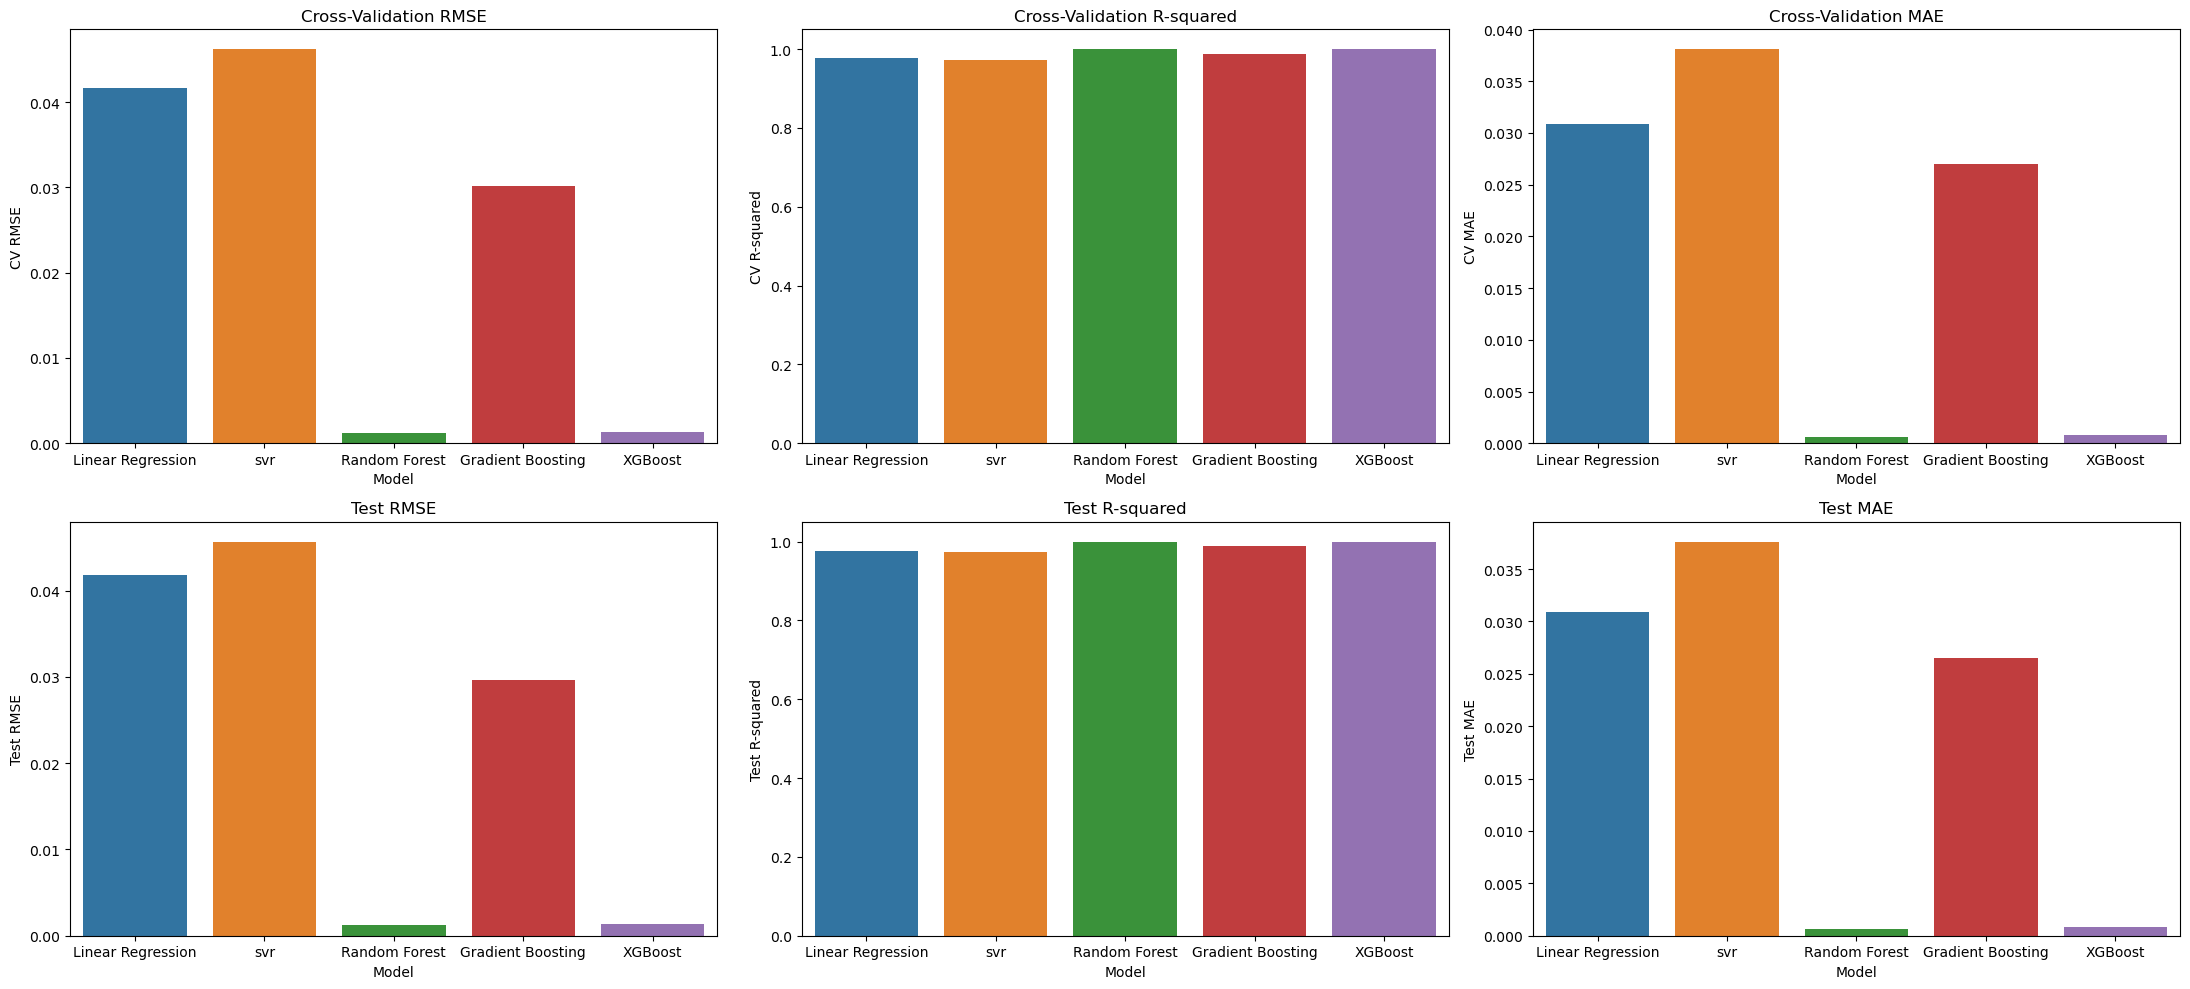

In [29]:
# Plotting function
def plot_model_performance(results_df):
    # Initialize the plot
    plt.figure(figsize=(22, 10))

    # Plot RMSE
    plt.subplot(2, 3, 1)
    sns.barplot(x='Model', y='CV RMSE', data=results_df)
    plt.title('Cross-Validation RMSE')

    # Plot R-squared
    plt.subplot(2, 3, 2)
    sns.barplot(x='Model', y='CV R-squared', data=results_df)
    plt.title('Cross-Validation R-squared')

    # Plot MAE
    plt.subplot(2, 3, 3)
    sns.barplot(x='Model', y='CV MAE', data=results_df)
    plt.title('Cross-Validation MAE')

    # Plot Test RMSE
    plt.subplot(2, 3, 4)
    sns.barplot(x='Model', y='Test RMSE', data=results_df)
    plt.title('Test RMSE')
    
    # Plot Test RMSE
    plt.subplot(2, 3, 5)
    sns.barplot(x='Model', y='Test R-squared', data=results_df)
    plt.title('Test R-squared')
    
    # Plot MAE
    plt.subplot(2, 3, 6)
    sns.barplot(x='Model', y='Test MAE', data=results_df)
    plt.title('Test MAE')
    
    plt.tight_layout()
    plt.show()

plot_model_performance(results_df)

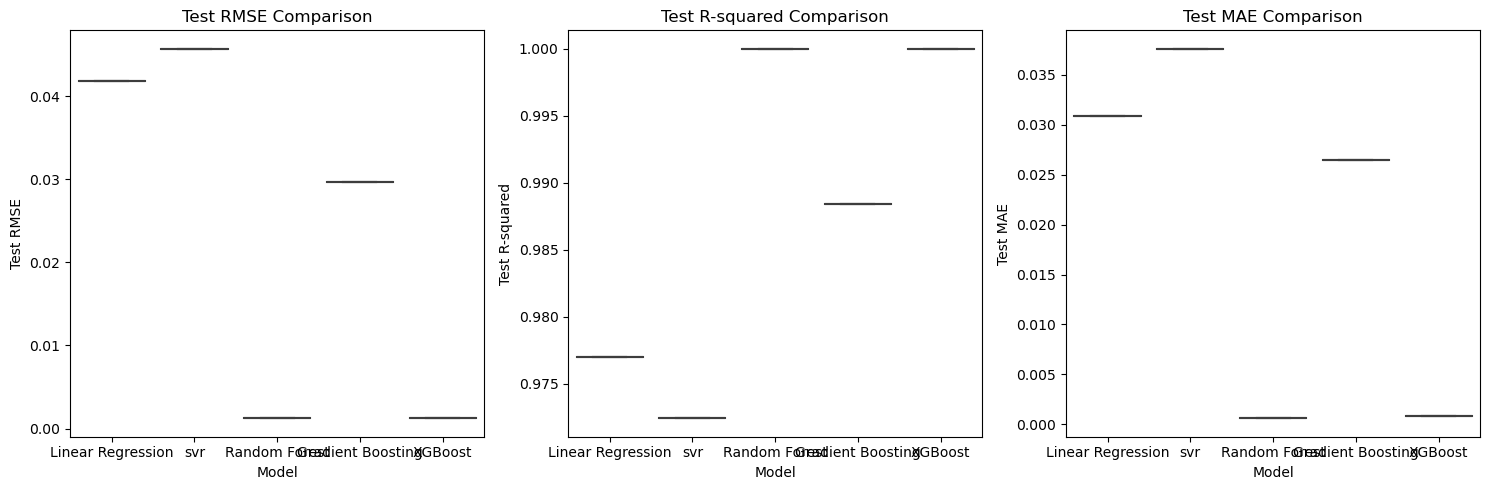

In [41]:
# Initialize the plot
plt.figure(figsize=(15, 5))

# Create box plots for Test RMSE
plt.subplot(1, 3, 1)
sns.boxplot(x='Model', y='Test RMSE', data=results_df)
plt.title('Test RMSE Comparison')

# Create box plots for Test R-squared
plt.subplot(1, 3, 2)
sns.boxplot(x='Model', y='Test R-squared', data=results_df)
plt.title('Test R-squared Comparison')

# Create box plots for Test MAE
plt.subplot(1, 3, 3)
sns.boxplot(x='Model', y='Test MAE', data=results_df)
plt.title('Test MAE Comparison')

plt.tight_layout()
plt.show()


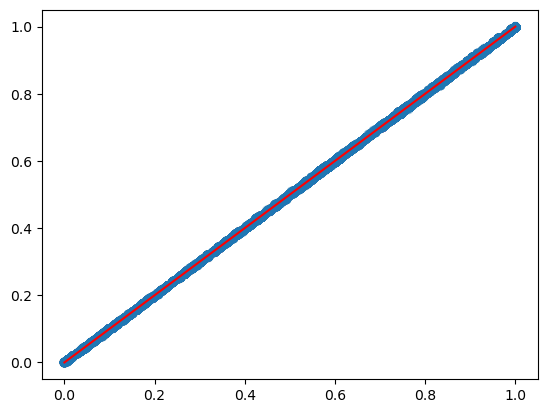

In [71]:
plt.scatter(y_test, y_pred_xgb, alpha=0.2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Train XGBoost model on the entire training set
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

ValueError: x and y must be the same size

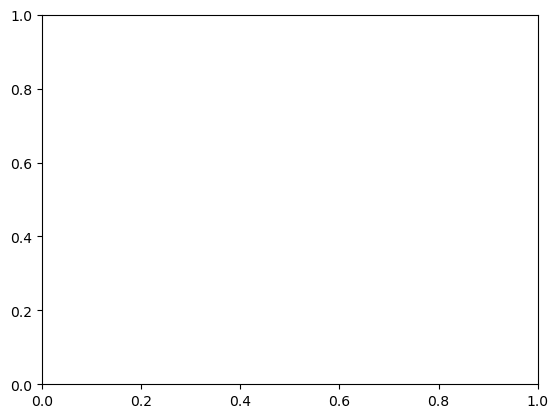

In [61]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred_xgb, color='blue', linewidth=3)
plt.show()

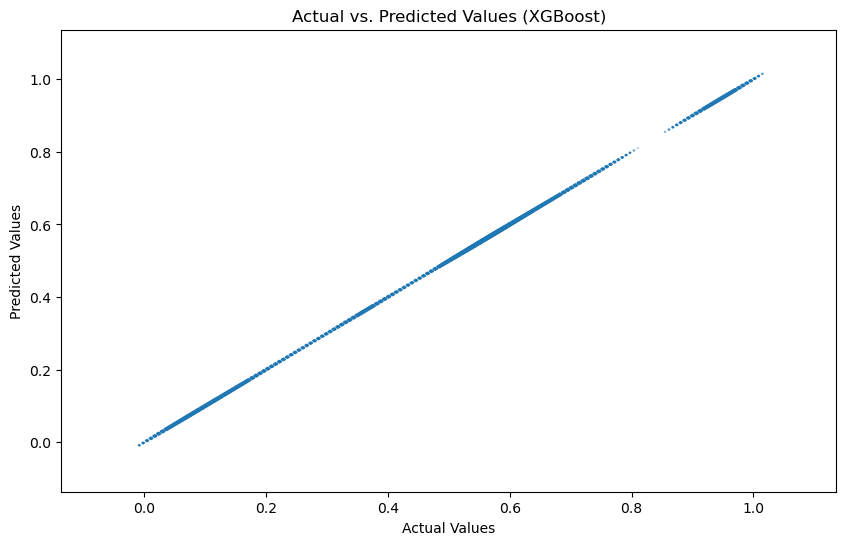

In [46]:
# Create a DataFrame for actual and predicted values
results_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xgb})

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot KDE for actual vs. predicted values
sns.kdeplot(data=results_xgb, x='Actual', y='Predicted')

# Set plot title and labels
plt.title('Actual vs. Predicted Values (XGBoost)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.show()

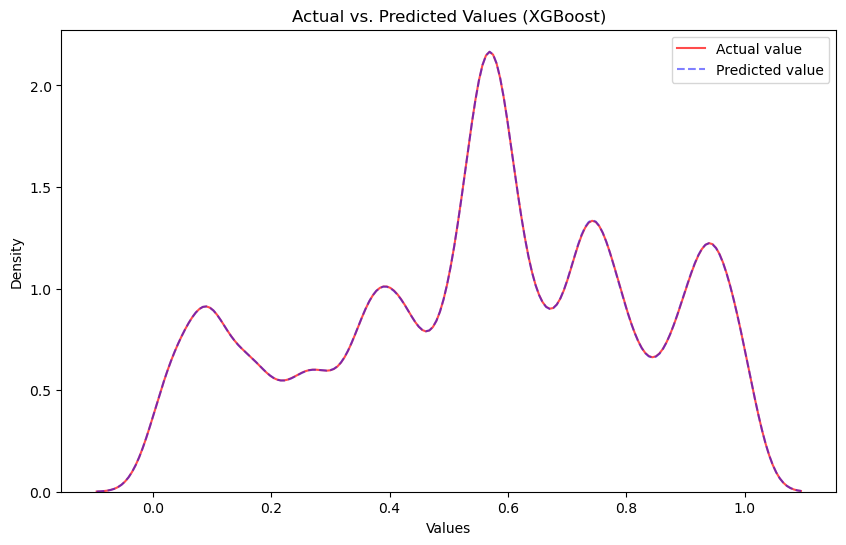

In [56]:
# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot KDE for actual values
sns.kdeplot(results_xgb['Actual'], color='r', label='Actual value', alpha=0.7)

# Plot KDE for predicted values
sns.kdeplot(results_xgb['Predicted'], color='b', label='Predicted value', alpha=0.5, linestyle='--')

# Set plot title and labels
plt.title('Actual vs. Predicted Values (XGBoost)')
plt.xlabel('Values')
plt.ylabel('Density')

# Add legend
plt.legend()

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


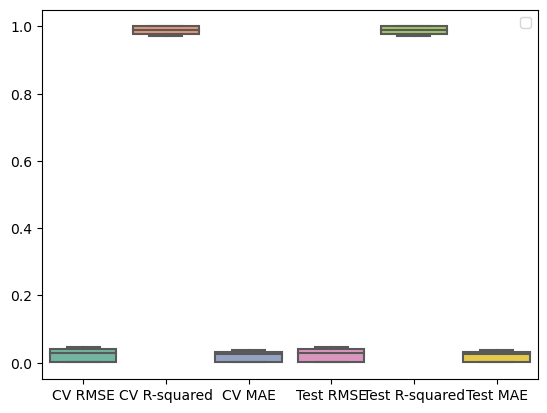

In [58]:
sns.boxplot(results_df, palette = 'Set2')
plt.legend()
plt.show()

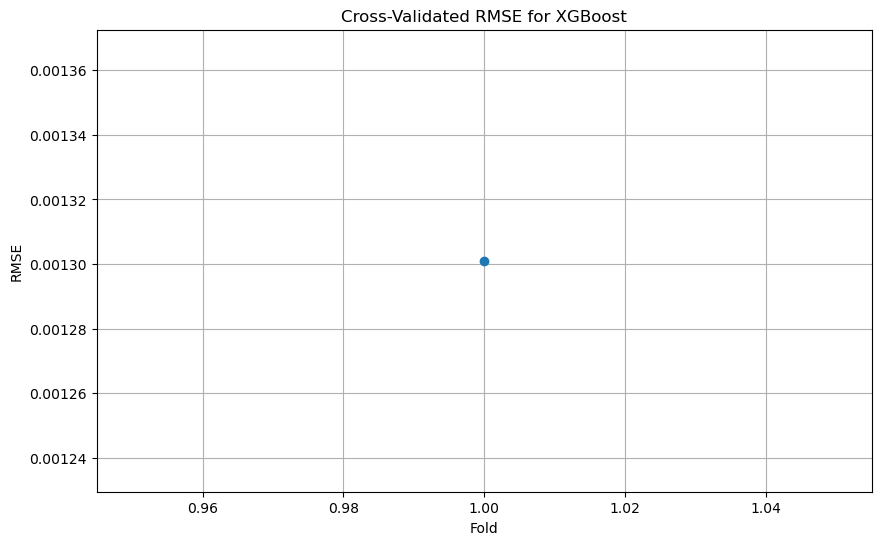

In [35]:
# Extract cross-validated RMSE scores for XGBoost
xgboost_cv_rmse = results_df.loc[results_df['Model'] == 'XGBoost', 'CV RMSE'].values

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot cross-validated RMSE for each fold
plt.plot(range(1, len(xgboost_cv_rmse) + 1), xgboost_cv_rmse, marker='o')

# Set plot title and labels
plt.title('Cross-Validated RMSE for XGBoost')
plt.xlabel('Fold')
plt.ylabel('RMSE')

plt.grid(True)
plt.show()


In [39]:
import timeit

# Function to cross-validate
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    
    # Training time measurement
    start_training = timeit.default_timer()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = [math.sqrt(-score) for score in scores]
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    end_training = timeit.default_timer()
    
    # Testing time measurement
    start_testing = timeit.default_timer()
    model.fit(X_train, y_train)
    end_testing = timeit.default_timer()
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    # Compute test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    print('')
    print('-'*25)
    print('Evaluation complete!')
    
    training_time = end_training - start_training
    testing_time = end_testing - start_testing
    
    return [name, np.mean(rmse_scores), np.mean(r2_scores), np.mean(mae_scores), test_rmse, test_r2, test_mae, training_time, testing_time]

# Instead of executing the loop, create a dictionary of models and functions
models_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
#     'Random Forest': RandomForestRegressor(random_state=42),
#     'Gradient Boosting': GradientBoostingRegressor(random_state=42),
#     'XGBoost': XGBRegressor(random_state=42)
}

# Loop through the dictionary to evaluate each model and measure time
results = []
for name, model in models_dict.items():
    result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
    results.append(result)

results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Training Time', 'Testing Time'])
results_df


Evaluating Linear Regression...

-------------------------
Evaluation complete!
Evaluating Ridge...

-------------------------
Evaluation complete!
Evaluating Lasso...

-------------------------
Evaluation complete!


,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Training Time,Testing Time
0,Linear Regression,0.117482,0.892085,0.082122,0.118045,0.890575,0.082368,1.314750,0.083970
1,Ridge,0.117481,0.892088,0.082072,0.118036,0.890592,0.082317,0.846663,0.045635
2,Lasso,0.357630,-0.000012,0.312263,0.356874,-0.000112,0.310879,1.051922,0.056745
